<a href="https://colab.research.google.com/github/crafid8182/wildfire-detector/blob/main/ai4all_wildfire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing kaggle library

In [ ]:
!pip install kaggle

Import all necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D,Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.python.framework import ops
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2

Mount google drive to create directory for the kaggle datatset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create directory, import kaggle API, download the dataset and unzip the downloaded files

In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset
! unzip wildfire-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 98% 1.42G/1.45G [00:07<00:00, 227MB/s]
100% 1.45G/1.45G [00:07<00:00, 217MB/s]


Create directories for the different types of data within the dataset for training, testing and validating

In [ ]:
train_dir = './train'
valid_dir = './valid'
test_dir = './test'

Downsize the data

In [ ]:
def load_images_from_folder(folder, max_images_per_class):
    images = []
    labels = []
    for label, subfolder in enumerate(["nowildfire", "wildfire"]):
        path = os.path.join(folder, subfolder)
        count = 0
        for filename in os.listdir(path):
            if count >= max_images_per_class:
                break
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (150, 150))  # Resize images to 150x150
                img = img / 255.0                  # Normalize the images to [0, 1]
                images.append(img)
                labels.append(label)
                count += 1
    return np.array(images), np.array(labels)

# Load the downsized dataset
train_images, train_labels = load_images_from_folder(train_dir, max_images_per_class=5000)
valid_images, valid_labels = load_images_from_folder(valid_dir, max_images_per_class=1000)
test_images, test_labels = load_images_from_folder(test_dir, max_images_per_class=1000)

print(f"Train images: {train_images.shape}, Train labels: {train_labels.shape}")
print(f"Valid images: {valid_images.shape}, Valid labels: {valid_labels.shape}")
print(f"Test images: {test_images.shape}, Test labels: {test_labels.shape}")


Train images: (10000, 150, 150, 3), Train labels: (10000,)
Valid images: (2000, 150, 150, 3), Valid labels: (2000,)
Test images: (2000, 150, 150, 3), Test labels: (2000,)


Fixes issue with labeling for the model to properly validate

In [ ]:
train_labels = to_categorical(train_labels, num_classes=2)
valid_labels = to_categorical(valid_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

In [ ]:
model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(2, activation='softmax'))  # Output layer with 2 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_images,
    train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=20,
    batch_size=32
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8667 - loss: 2.4458 - val_accuracy: 0.7310 - val_loss: 0.6252
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9151 - loss: 0.2699 - val_accuracy: 0.8870 - val_loss: 0.2332
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9174 - loss: 0.2088 - val_accuracy: 0.9435 - val_loss: 0.1338
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9193 - loss: 0.2257 - val_accuracy: 0.7705 - val_loss: 0.4300
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8940 - loss: 0.3081 - val_accuracy: 0.8450 - val_loss: 0.4082
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9195 - loss: 0.2142 - val_accuracy: 0.9450 - val_loss: 0.1508
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9182 - loss: 0.1979 - val_accuracy: 0.9490 - val_loss: 0.1530
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9260 - loss: 0.1761 - val_accuracy: 

Find model accuracy on average

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9622 - loss: 0.2001
Test Accuracy: 0.95


Create a visual to present the model

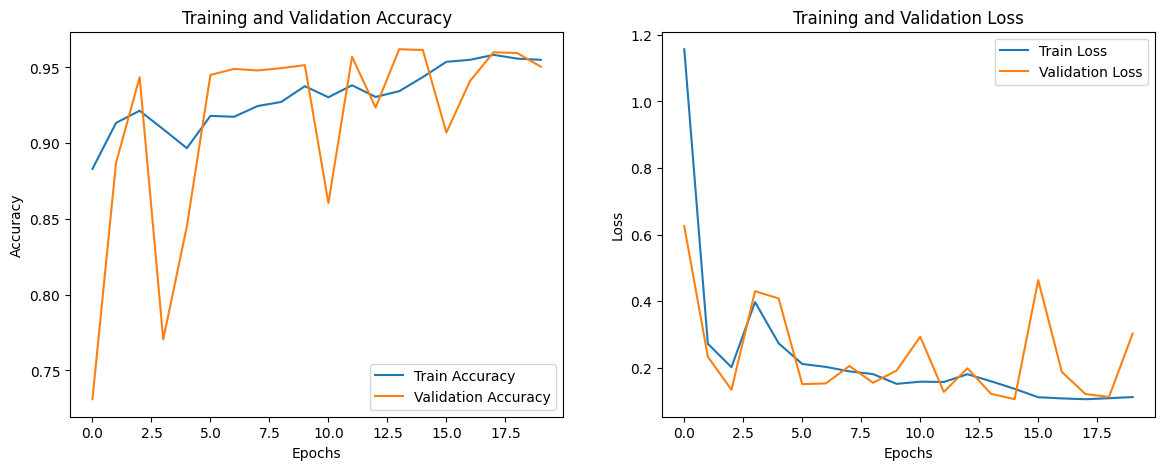

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


Function to detect if the image contains wildfire or not, and calls the function 10 times with 5 wildfire images and 5 nowildfire images to test the model

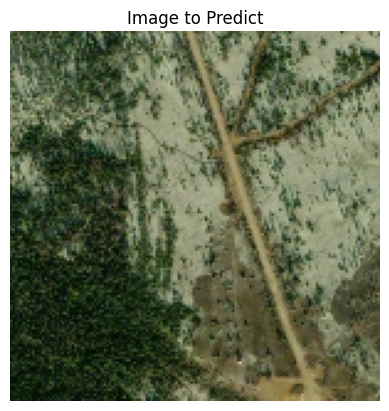

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Wildfire detected


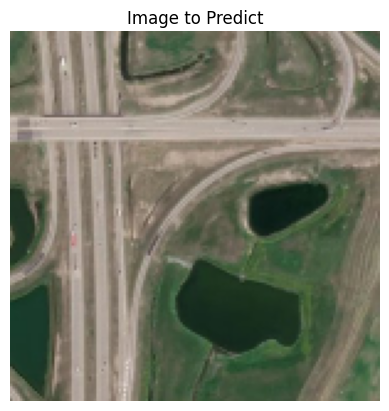

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
No wildfire detected


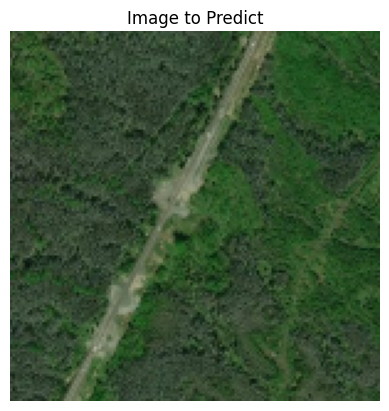

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Wildfire detected


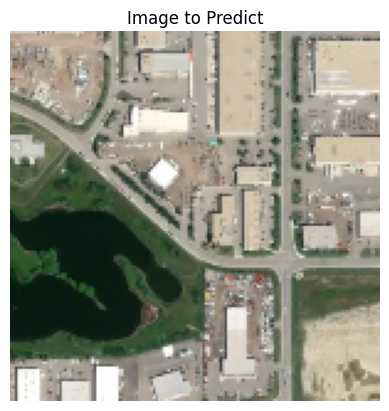

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
No wildfire detected


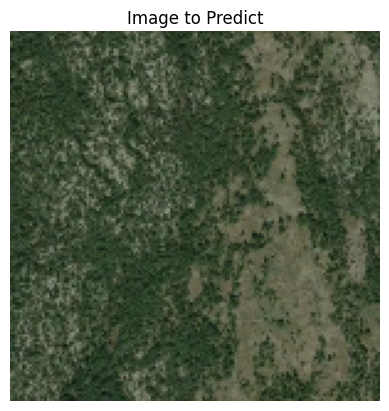

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Wildfire detected


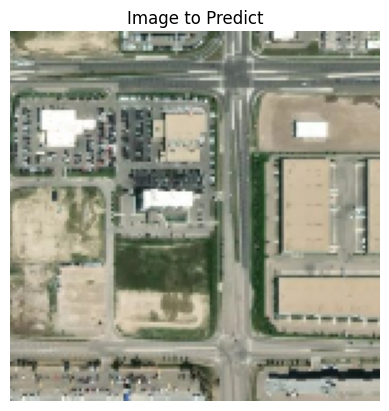

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
No wildfire detected


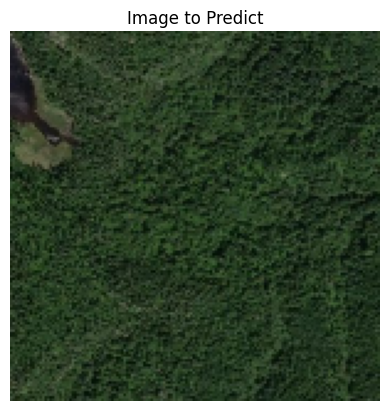

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Wildfire detected


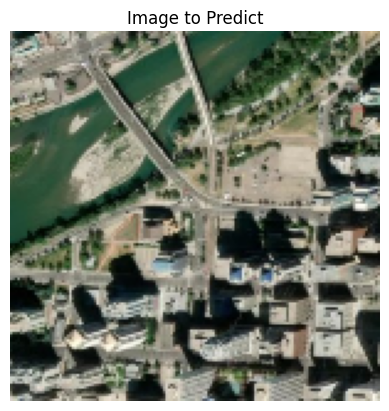

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
No wildfire detected


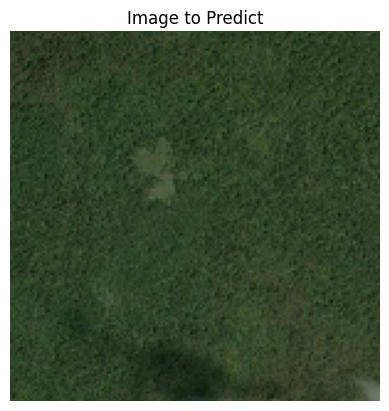

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Wildfire detected


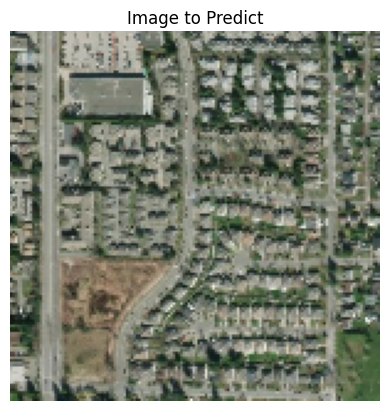

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
No wildfire detected


In [ ]:
def predict_image(image_path, model):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    # Error handling in case of wroing path
    if img is None:
        print(f"Error: Image not found at path: {image_path}")
        return

    # Resize to match the input size of the model
    img_resized = cv2.resize(img, (150, 150))

    # Display the image (before normalization, as normalization changes the data type)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Image to Predict")
    plt.show()

    # Normalize the image for prediction
    img_normalized = img_resized / 255.0  # Normalize the image
    img_input = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_input)

    # Print the prediction result
    if prediction[0][1] > 0.5:
        print("Wildfire detected")
    else:
        print("No wildfire detected")


predict_image('/content/test/wildfire/-61.83052,50.28957.jpg', model)#
predict_image('/content/test/nowildfire/-113.918016,50.978447.jpg', model)
predict_image('/content/test/wildfire/-66.21763,50.27608.jpg', model)#
predict_image('/content/test/nowildfire/-113.967129,50.954545.jpg', model)
predict_image('/content/test/wildfire/-67.68531,51.27248.jpg', model)#
predict_image('/content/test/nowildfire/-114.002558,51.152517.jpg', model)
predict_image('/content/test/wildfire/-68.955,48.9717.jpg', model)#
predict_image('/content/test/nowildfire/-114.083649,51.049811.jpg', model)
predict_image('/content/test/wildfire/-70.24721,49.8711.jpg', model)#
predict_image('/content/test/nowildfire/-122.887404,49.144591.jpg', model)
